This notebook provides an example to run the hybrid mini-grid optimization for a single settlement.
Hourly PV and temperature data are retrieved from renewables.ninja, and the hourly loads are estimated based on annual demand and example load curve shapes for each Tier of the Multi-Tier Franework. Both can be replaced if better data is available.

# Import neccessary packages

In [70]:
from src.mgoptimization.hybrids import *
from src.mgoptimization.pso import *
import os

# Location of settlement

In [71]:
long = -3
lat = 24

# Retrieve solar resource data for the location

Select where to save the PV data

In [72]:
pv_data_folder = 'pv'

Enter your renewables.ninja token

In [73]:
token = ''

This cell retrieves the PV data from renewables.ninja using your token

In [74]:
get_pv_data(lat, long, token, pv_data_folder)

In [75]:
hourly_ghi, hourly_temp = read_environmental_data(os.path.join(pv_data_folder, 'pv_data_lat_{}_long_{}.csv'.format(lat, long)))

# Calculate hourly load curve

The below cells estimates the load (kWh) for each hour in the year based on the annual demand, and example load curve shapes for each Tier of the Multi-Tier Framework. If the hourly load curve is already known for the settlement, replace the load_curve variable with that load curve.

In [76]:
demand = 365*361 # Total annual demand (kWh) in location
tier = 2  # Average Tier of the Multi-Tier Framework in the location.

In [77]:
load_curve = calc_load_curve(tier, demand)

# Run the optimization to find the best combination of PV, diesel and batteries, as well as the corresponding LCOE

Update the costs and other techno-economic variables below

In [82]:
result = optimizer(diesel_price=0.5, # USD/liter of diesel fuel
                   hourly_ghi=hourly_ghi,
                   hourly_temp=hourly_temp,
                   load_curve=load_curve,
                   start_year=2024,
                   end_year=2034,
                   discount_rate=0.08,
                   diesel_cost=378,  # diesel generator capital cost, USD/kW rated power
                   battery_cost=589,  # battery capital capital cost, USD/kWh of storage capacity
                   full_life_cycles=2000, #full battery cycles before failure
                   battery_inverter_cost=608,  # USD/kW
                   pv_cost=1147,  # PV panel capital cost, USD/kW peak power
                   pv_inverter=0, # PV inverter cost, USD/kW peak power, set to 0 if already included in pv_cost
                   charge_controller=0, # PV charge controller cost, USD/kW peak power, set to 0 if already included in pv_cost
                   diesel_limit=0.5, # Maximum share of generation over a year coming from diesel generator
                   lpsp_max=0.005,  # maximum loss of load allowed over the year
                   iterations=100,  # The max number of iterations used in the Particle Swarm Optimization (PSO)
                   n_particles=100,  # The number of particles used in the Particle Swarm Optimization
                   verbose=True,  #  PSO parameter
                   options={'c1': 0.8, 'c2': 1, 'w': 0.6})  #  PSO parameter

print('Generation LCOE is found to be {} USD/kWh'.format(round(result['gen_lcoe'], 2)))
print('Optimum PV capacity is found to be {} kW'.format(round(result['pv_capacity'], 1)))
print('Optimum diesel capacity is found to be {} kW'.format(round(result['diesel_gen_capacity'], 1)))
print('Optimum battery capacity is found to be {} kWh'.format(round(result['battery_capacity'], 1)))
print('NPC of optimum configuration is {} USD'.format(int(round(result['npc'], 0))))
print('Battery life of optimum configuration is {} years'.format(round(result['battery_life'], 0)))

2024-02-28 19:15:56,888 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 1, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|100/100, best_cost=0.27
2024-02-28 19:16:21,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.27047089568855875, best pos: [37.26320103 67.71810496 23.7182485 ]


Generation LCOE is found to be 0.27 USD/kWh
Optimum PV capacity is found to be 37.3 kW
Optimum diesel capacity is found to be 23.7 kW
Optimum battery capacity is found to be 84.6 kWh
NPC of optimum configuration is 283460 USD
Battery life of optimum configuration is 5 years


# Visualize the results for two example days

In [83]:
import matplotlib.pyplot as plt
import numpy as np

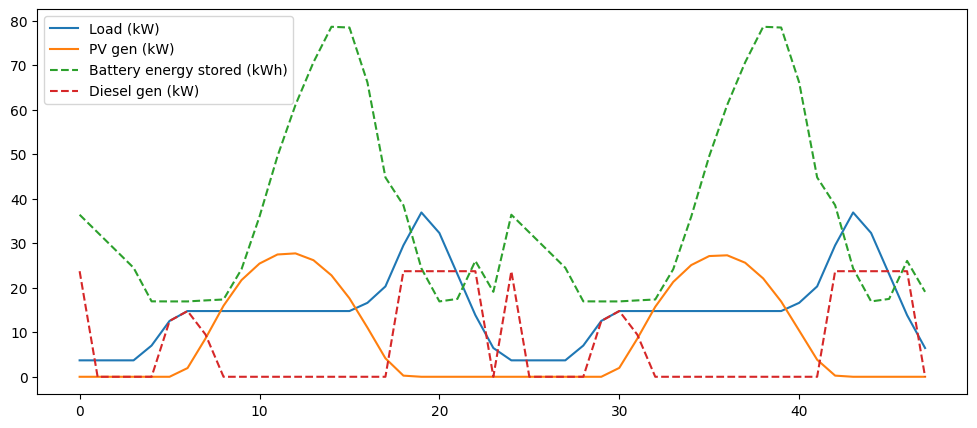

In [84]:
load = np.array(load_curve[2400:2448])
pv_gen = np.array(result['hourly_pv_gen'][2400:2448])
diesel_gen = np.array(result['hourly_diesel_gen'][2400:2448])
battery_soc = np.array(result['battery_hourly_soc'][2400:2448])
battery_usage = result['battery_capacity'] * battery_soc

plt.figure(figsize=(12, 5))
plt.plot(load, label='Load (kW)')
plt.plot(pv_gen, label='PV gen (kW)')
plt.plot(battery_usage, '--', label='Battery energy stored (kWh)')
plt.plot(diesel_gen, '--', label='Diesel gen (kW)')
plt.legend(loc='upper left')